<a href="https://colab.research.google.com/github/krishna1234sri/fmml-lab-assignments/blob/main/FMML_Course_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [1]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-05-16 00:36:19--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   268MB/s    in 0.3s    

2023-05-16 00:36:22 (268 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

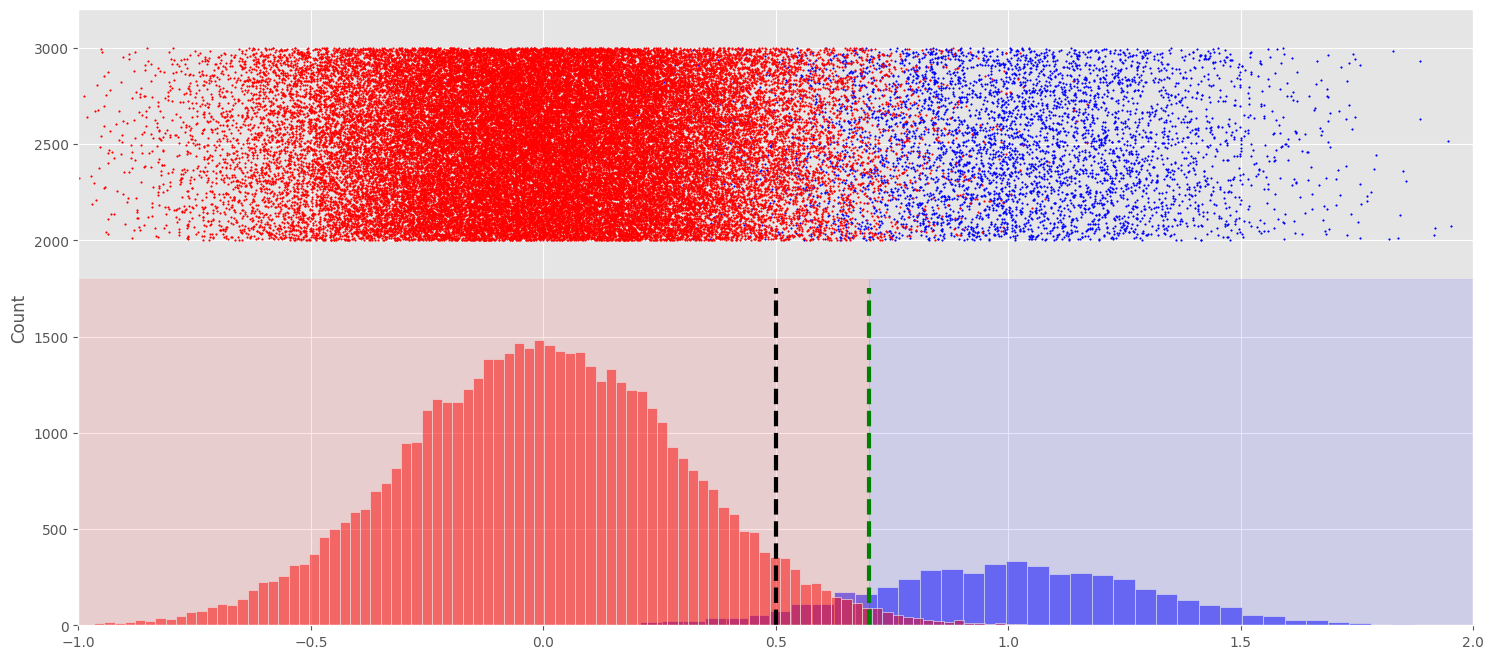

In [3]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

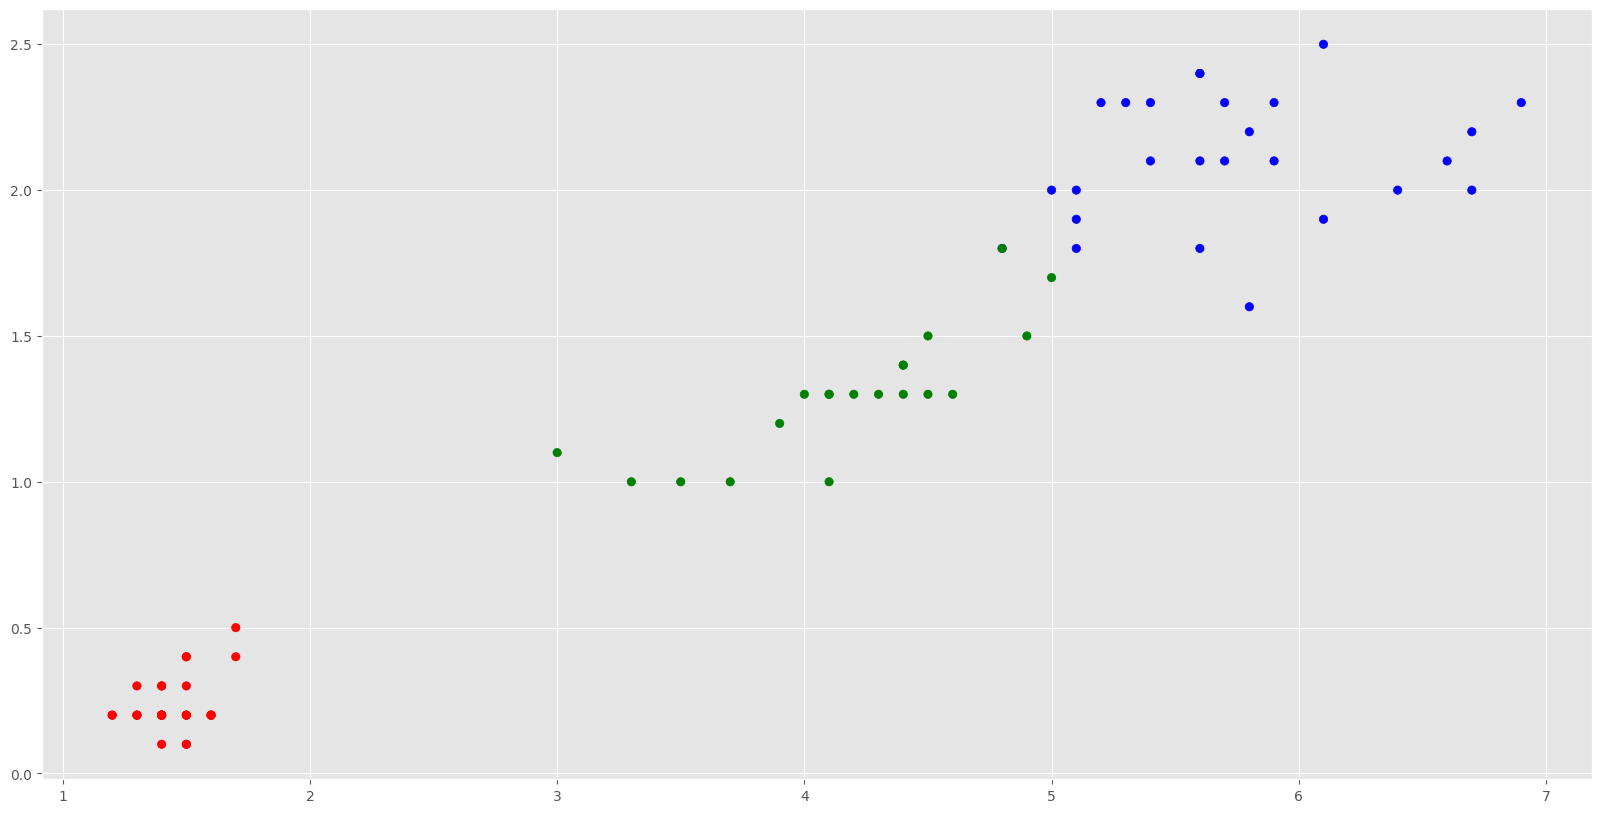

In [6]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

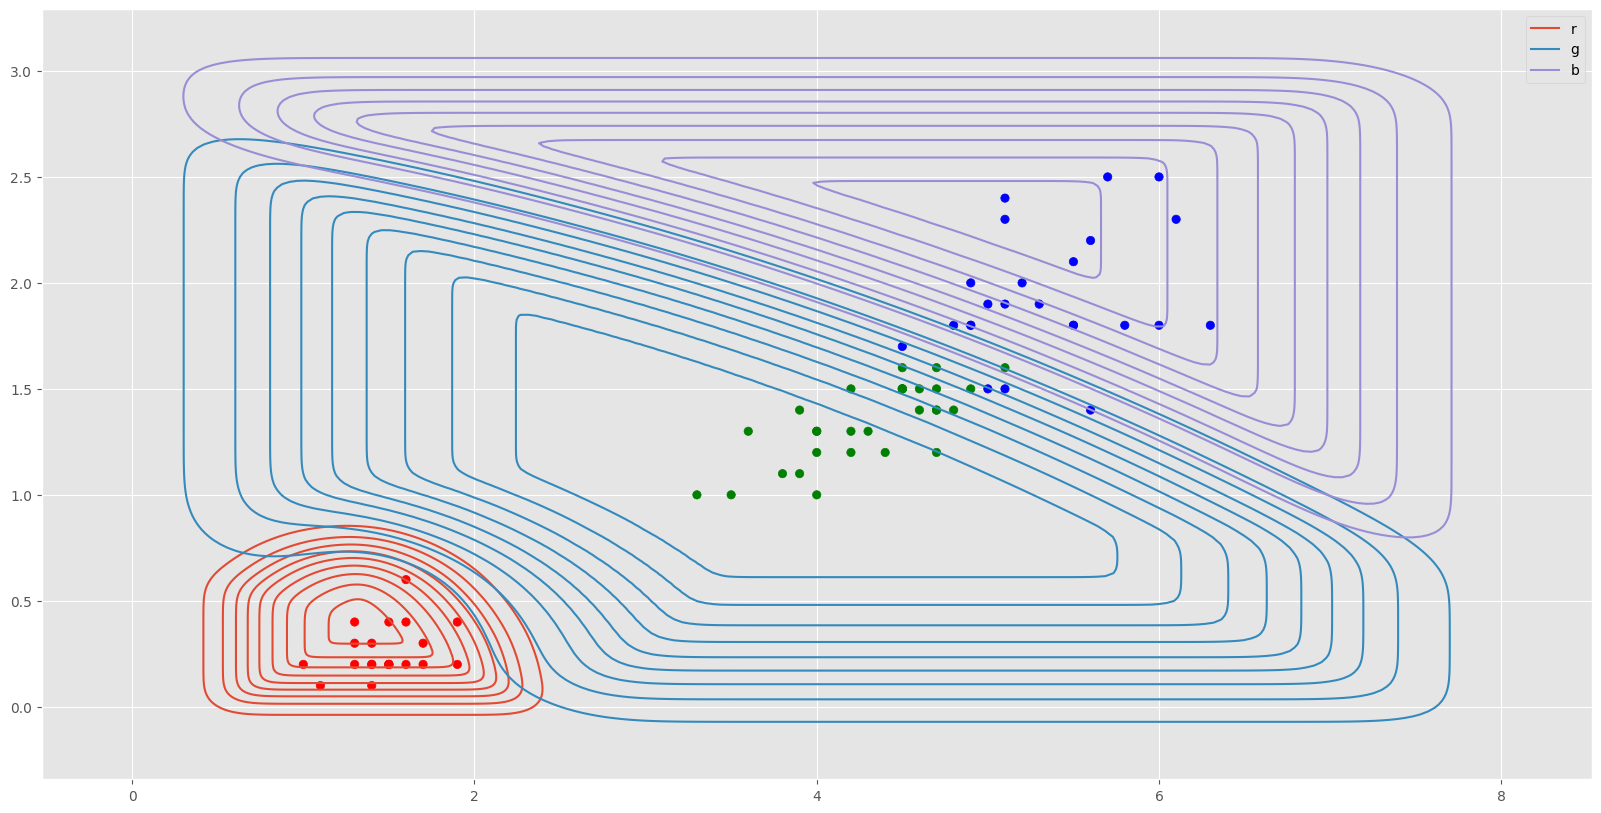

In [7]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [8]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [9]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [10]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False), 
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split() 
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
6337,1611.04920v2,Gaussian graphical models (GGMs) are widely us...,stat,Unsupervised Learning with Truncated Gaussian ...,2016,"[graphical, statistical, inference, ubiquitous..."
7862,1009.4574v1,Text classification is the process of classify...,cs,A hybrid learning algorithm for text classific...,2010,"[classification, classifying, documents, prede..."
12313,1711.07077v2,Although many contextual bandit algorithms hav...,stat,Estimation Considerations in Contextual Bandits,2017,"[contextual, algorithms, theoretical, guarante..."
22034,1312.5386v1,Probabilistic models often have parameters tha...,stat,Detecting Parameter Symmetries in Probabilisti...,2013,"[probabilistic, parameters, translated, otherw..."
12526,1802.07400v1,Learning-to-rank techniques have proven to be ...,stat,Direct Learning to Rank and Rerank,2018,"[techniques, extremely, prioritization, estima..."
...,...,...,...,...,...,...
11863,1703.00564v2,Molecular machine learning has been maturing r...,cs,MoleculeNet: A Benchmark for Molecular Machine...,2017,"[molecular, algorithms, increasingly, predicti..."
12662,1104.2580v2,Given the ever increasing bandwidth of the vis...,cs,Hypothesize and Bound: A Computational Focus o...,2011,"[increasing, bandwidth, information, available..."
10872,1503.03585v8,A central problem in machine learning involves...,cs,Deep Unsupervised Learning using Nonequilibriu...,2015,"[probability, distributions, inference, evalua..."
26100,1608.06713v1,In this paper we propose a method for transfer...,cs,Transfer Learning for Endoscopic Image Classif...,2016,"[endoscopic, transferring, different, endoscop..."


In [11]:
df['keywords']

6337     [graphical, statistical, inference, ubiquitous...
7862     [classification, classifying, documents, prede...
12313    [contextual, algorithms, theoretical, guarante...
22034    [probabilistic, parameters, translated, otherw...
12526    [techniques, extremely, prioritization, estima...
                               ...                        
34974    [subscribe, algorithms, computing, scalability...
8718     [challenging, solutions, successful, remarkabl...
40755    [polynomial, algorithm, population, approximat...
29488    [accidents, increased, significantly, accident...
22496    [reparameterization, gradients, variational, o...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [12]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]), 
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8730 words.
Out of those 4520 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule. 

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [13]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4520,), (4520, 2))

In [14]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7983333333333333


### Visualizing a few examples

In [15]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [16]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [17]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [18]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [20]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	processing (0.10032246506628449)
	architecture (0.08061626657112146)
	knowledge (0.12576137585094949)
	segmentation (0.073450376209244)
	experimental (0.13543532783948406)
	detection (0.11572912934432103)
	information (0.25833034754568257)
	different (0.26907918308849876)
	recognition (0.1307774991042637)
	convolutional (0.13400214976710856)

Some Statistics words are:
	theoretical (0.1408661025385764)
	algorithm (0.38974614235938276)
	statistical (0.15579890492782478)
	stochastic (0.14036834245893479)
	variables (0.14733698357391736)
	inference (0.1916376306620209)
	dimensional (0.1752115480338477)
	estimation (0.1717272274763564)
	distribution (0.19213539074166253)
	regression (0.1796913887506222)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [21]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]), 
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [22]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	prejudice
	oftentimes
	anopheles
	factoring
	experimenter
	blockwise
	interpolates
	metabolic
	validator
	omnipresent
	transcriptional
	censoring
	schizophrenia
	undetermined
	additively
	poisoning
	robustify
	chronological
	resolvable
	exponents
Some words which never appear in Statistics papers:
	favourable
	naturalness
	realisation
	butterfly
	coreference
	webquestions
	empowering
	groundtruth
	computerized
	basically
	animation
	orderless
	textureless
	compilation
	propositional
	compilations
	cooperative
	affiliated
	medications
	maneuvers


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0835646006783845e-05


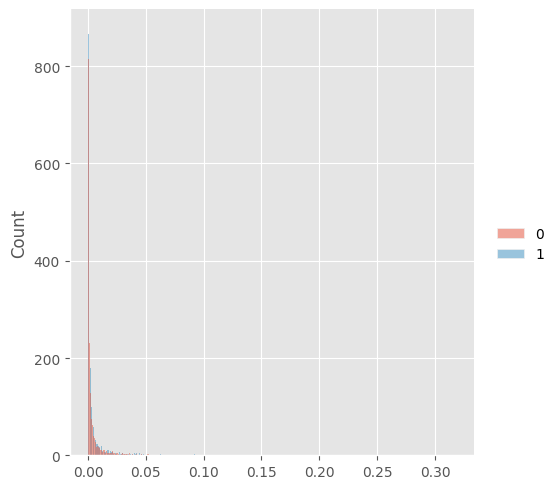

In [23]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [24]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7733333333333333
